In [15]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

### Let's try loading with 28x28 image

In [4]:
# Load MNIST 28x28 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# Expand dims → (N, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# One-hot encode labels
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot  = tf.keras.utils.to_categorical(y_test, 10)

# --- 🔹 Base Augmentation ---
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest"
)
datagen.fit(X_train)

# --- 🔹 Add Random Inversion Function ---
def random_invert(x):
    """Randomly invert image colors with 50% chance."""
    if np.random.rand() < 0.5:
        return 1.0 - x
    return x

# Wrap datagen with custom preprocessing
def augmented_generator(X, y, batch_size=64):
    gen = datagen.flow(X, y, batch_size=batch_size)
    while True:
        batch_x, batch_y = next(gen)
        # Apply inversion to each image in batch
        batch_x = np.array([random_invert(img) for img in batch_x])
        yield batch_x, batch_y

# --- 🔹 Model ---
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# --- 🔹 Train with augmented + inverted data ---
batch_size = 64
epochs = 30

history = model.fit(
    augmented_generator(X_train, y_train_onehot, batch_size),
    validation_data=(X_test, y_test_onehot),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    verbose=1
)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/30
937/937 [==============================] - 14s 13ms/step - loss: 1.1243 - accuracy: 0.6203 - val_loss: 0.2303 - val_accuracy: 0.9281
Epoch 2/30
937/937 [==============================] - 12s 12ms/step - loss: 0.5640 - accuracy: 0.8215 - val_loss: 0.1939 - val_accuracy: 0.9399
Epoch 3/30
937/937 [==============================] - 11s 12ms/step - loss: 0.4301 - accuracy: 0.8660 - val_loss: 0.1459 - val_accuracy: 0.9565
Epoch 4/30
937/937 [==============================] - 11s 12ms/step - loss: 0.3758 - accuracy: 0.8820 - val_loss: 0.1347 - val_accuracy: 0.9574
Epoch 5/30
937/937 [==============================] - 12s 13ms/step - loss: 0.3443 - accuracy: 0.8930 - val_loss: 0.1341 - val_accuracy: 0.9584
Epoch 6/30
937/937 [==============================] - 11s 12ms/step - loss: 0.3156 - accuracy: 0.9014 - val_loss: 0.1197 - val_accuracy: 0.9639
Epoch 7/30
937/937 [==============================] - 11s 12ms/step - l

In [5]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
model.summary()

# INT8 TFLite conversion
def representative_dataset():
    for i in range(1000):
        img = X_train[i:i+1].astype(np.float32)
        yield [img.reshape(1, 784)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("digits_model_28x28_int8_augmented.tflite", "wb") as f:
    f.write(tflite_model)

print("INT8 TFLite model with inversion saved. Size:", len(tflite_model), "bytes")

Test Accuracy: 0.9715
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets writt

C:\Users\User\.conda\envs\tinyML\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INT8 TFLite model with inversion saved. Size: 115184 bytes


In [2]:
# Check model layer wise data types
interpreter = tf.lite.Interpreter(model_path="digits_model_28x28_int8_augmented.tflite")
interpreter.allocate_tensors()

# Get all tensors
tensor_details = interpreter.get_tensor_details()

print("=== Tensor Data Types ===")
for t in tensor_details:
    print(f"{t['name']:<60} {t['dtype']}")

=== Tensor Data Types ===
serving_default_flatten_input:0                              <class 'numpy.int8'>
sequential/flatten/Const                                     <class 'numpy.int32'>
sequential/dense_3/BiasAdd/ReadVariableOp                    <class 'numpy.int32'>
sequential/dense_3/MatMul                                    <class 'numpy.int8'>
sequential/dense_2/BiasAdd/ReadVariableOp                    <class 'numpy.int32'>
sequential/dense_2/MatMul                                    <class 'numpy.int8'>
sequential/dense_1/BiasAdd/ReadVariableOp                    <class 'numpy.int32'>
sequential/dense_1/MatMul                                    <class 'numpy.int8'>
sequential/dense/BiasAdd/ReadVariableOp                      <class 'numpy.int32'>
sequential/dense/MatMul                                      <class 'numpy.int8'>
sequential/flatten/Reshape                                   <class 'numpy.int8'>
sequential/dense/MatMul;sequential/dense/Relu;sequential/dense/Bias

In [3]:
# Sanity check
interpreter = tf.lite.Interpreter(model_path="digits_model_28x28_int8_augmented.tflite")
interpreter.allocate_tensors()
details = interpreter.get_tensor_details()

float_tensors = [d['name'] for d in details if d['dtype'] == np.float32]
print("Float tensors:", float_tensors if float_tensors else "None ✅ Fully int8")

Float tensors: None ✅ Fully int8


In [4]:
for d in interpreter.get_signature_list():
    print(d)

print("\n=== Operator List ===")
for op in interpreter._get_ops_details():
    print(op["op_name"])


serving_default

=== Operator List ===
RESHAPE
FULLY_CONNECTED
FULLY_CONNECTED
FULLY_CONNECTED
FULLY_CONNECTED
SOFTMAX


In [ ]:
!xxd -i digits_model_28x28_int8_augmented.tflite > digits_model_28x28_int8_augmented.h

In [7]:
def run_inference_on_directory(model_path, image_dir, cols=5):
    """
    Run TFLite inference on all images in a directory and display results in a grid.
    
    Args:
        model_path: path to the .tflite model
        image_dir: directory containing images
        cols: number of columns in display grid (default 5)
    """
    # --- Load TFLite model ---
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # --- Gather image paths ---
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    total = len(image_paths)
    if total == 0:
        print("No images found in:", image_dir)
        return

    # --- Auto calculate rows ---
    rows = (total // cols) + (1 if total % cols != 0 else 0)
    
    images, preds = [], []
    
    for img_path in image_paths:
        img = Image.open(img_path).convert("L").resize((28, 28))
        img_np = np.array(img, dtype=np.float32) / 255.0
        img_np = np.expand_dims(img_np, axis=(0, -1))  # (1,28,28,1)
        
        # Quantize if model expects int8
        if input_details[0]['dtype'] == np.int8:
            scale, zero_point = input_details[0]['quantization']
            img_np = img_np / scale + zero_point
            img_np = np.clip(img_np, -128, 127).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], img_np)
        interpreter.invoke()
        
        output_data = interpreter.get_tensor(output_details[0]['index'])
        if output_details[0]['dtype'] == np.int8:
            scale, zero_point = output_details[0]['quantization']
            output_data = (output_data.astype(np.float32) - zero_point) * scale

        pred = np.argmax(output_data)
        preds.append(pred)
        images.append(np.array(img))

    # --- Plot results ---
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].set_title(f"Pred: {preds[i]}", fontsize=10)
        axes[i].axis("off")

    # Hide unused subplots
    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    

## Test results

### 1. Test on Images - From Mnist Test

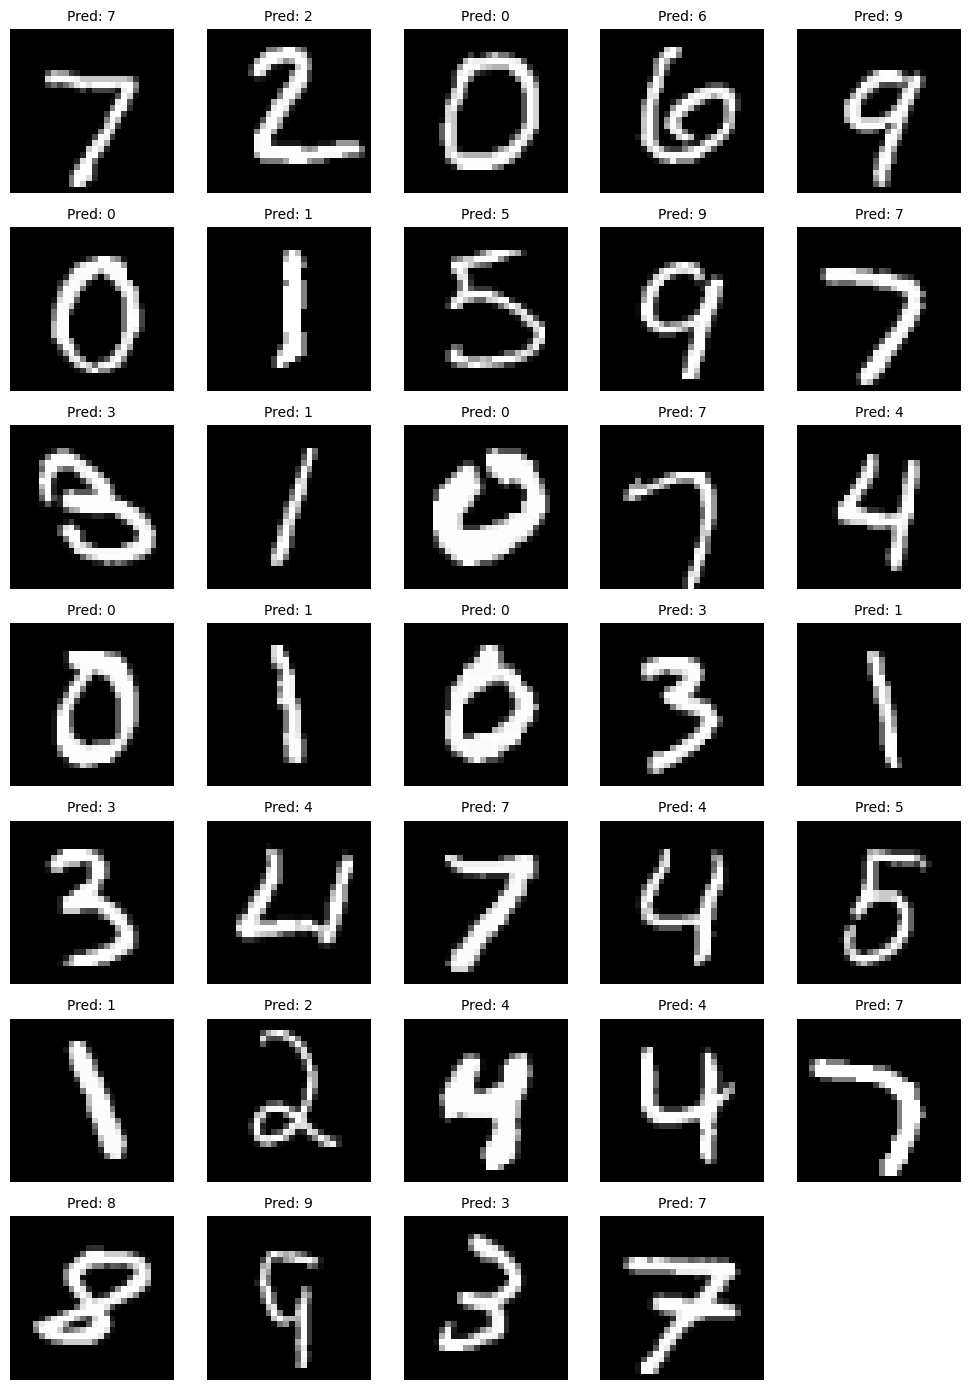

In [16]:
run_inference_on_directory(
    model_path="digits_model_28x28_int8_augmented.tflite", 
    image_dir="../../Dataset/MNIST_ORG/images",
    cols=5)

### 2. Test on images from the internet

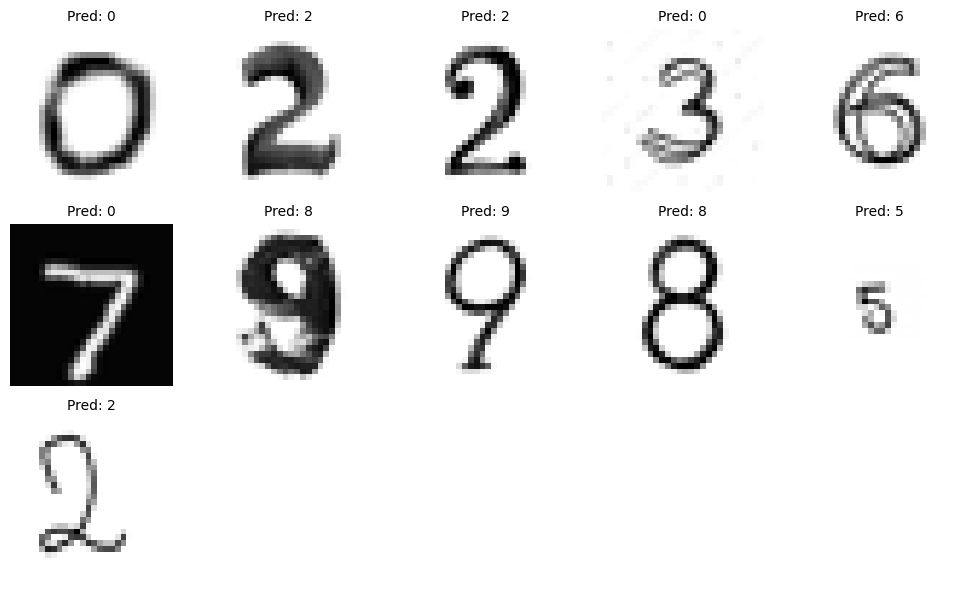

In [17]:
run_inference_on_directory(
    model_path="digits_model_28x28_int8_augmented.tflite", 
    image_dir="../../Dataset/internet/",
    cols=5)

### 3. Test on self written images

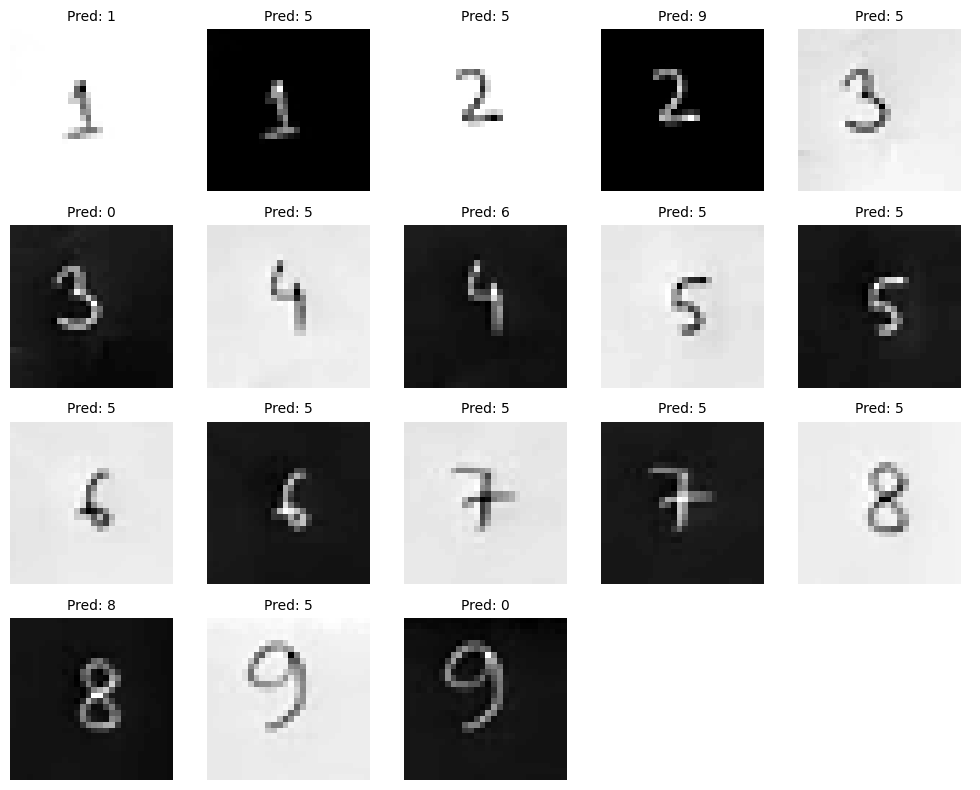

In [18]:
run_inference_on_directory(
    model_path="digits_model_28x28_int8_augmented.tflite", 
    image_dir="../../Dataset/self/",
    cols=5)